In [40]:
def is_valid_image(file_path):
    try:
        # Try to open the image file
        image = tf.io.read_file(file_path)
        image = tf.image.decode_jpeg(image, channels=3)  # Use other decoders if needed
        return True
    except tf.errors.InvalidArgumentError:
        return False  # Return False if the image can't be decoded

In [41]:
def load_and_preprocess_image(file_path, image_size=(224, 224)):
    # Convert the Tensor to a string
    file_path = tf.strings.as_string(file_path)

    # Define a function to load and preprocess the image
    def _load_image(path):
        # Decode the file path as a string
        path = path.numpy().decode("utf-8")
        img = tf.keras.utils.load_img(path, target_size=image_size)
        img = tf.keras.utils.img_to_array(img) / 255.0  # Normalize to [0, 1]
        return img

    # Use tf.py_function to call the Python function
    image = tf.py_function(func=_load_image, inp=[file_path], Tout=tf.float32)
    image.set_shape((*image_size, 3))  # Explicitly set shape
    return image

def create_tf_dataset(file_paths, labels, image_size=(224, 224), batch_size=32, shuffle=True):
    # Convert file paths and labels into a TensorFlow Dataset
    dataset = tf.data.Dataset.from_tensor_slices((file_paths, labels))
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(file_paths))
    dataset = dataset.map(
        lambda x, y: (load_and_preprocess_image(x, image_size=image_size), y),
        num_parallel_calls=tf.data.AUTOTUNE,
    )
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset


In [42]:
# Try downloading the dataset again (ensure your Kaggle API credentials are set up properly)
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
chest-xray-pneumonia.zip: Skipping, found more recently modified local copy (use --force to force download)


In [43]:
# Unzip files if applicable
!unzip /content/*.zip -d /content/

Archive:  /content/chest-xray-pneumonia.zip
replace /content/chest_xray/__MACOSX/._chest_xray? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


# <font color ='purple'>Let's start by Importing the required libraries </font>

In [44]:
import numpy as np  # for linear algebra
import pandas as pd  # for data processing
import matplotlib.pyplot as plt  # for plotting things
import os
from PIL import Image

# Install the latest version of TensorFlow
#!pip install --upgrade tensorflow


# Keras Libraries (from tensorflow.keras)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.layers import Input
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight

 ## <font color='purple'>  Our data is located in three folders:</font>
   
1. train= contains the training data/images for teaching our model.
2.  val= contains images which we will use to validate our model. The purpose of this data set is to prevent our model from **Overfitting**. Overfitting is when your model gets a little too comofortable with the training data and can't handle data it hasn't see....too well.
3. test = this contains the data that we use to test the model once it has learned the relationships between the images and their label (Pneumonia/Not-Pneumonia)

       
    
    

In [45]:


# Define the base directory
dir = '/content/chest_xray/chest_xray'

# List the contents of the main directory
mainDIR = os.listdir(dir)
print(mainDIR)

# Construct the paths to train, validation, and test folders
train_folder = os.path.join(dir, 'train')
val_folder = os.path.join(dir, 'val')
test_folder = os.path.join(dir, 'test')

['test', 'train', '.DS_Store', 'val']


## Let's set up the training and testing folders.


In [46]:
# train
os.listdir(train_folder)
train_n = os.path.join(train_folder,'NORMAL/')
train_p = os.path.join(train_folder,'PNEUMONIA/')


## Let's take a look at some of the pictures.



1342
normal picture title:  NORMAL2-IM-0662-0001.jpeg
pneumonia picture title: person1224_virus_2074.jpeg


Text(0.5, 1.0, 'Pneumonia')

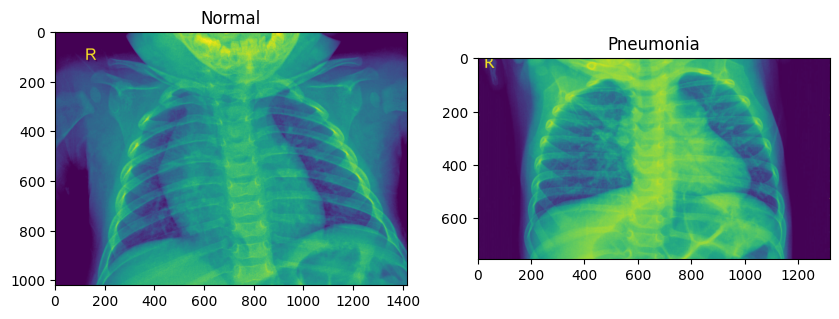

In [47]:
#Normal pic
print(len(os.listdir(train_n)))
rand_norm= np.random.randint(0,len(os.listdir(train_n)))
norm_pic = os.listdir(train_n)[rand_norm]
print('normal picture title: ',norm_pic)

norm_pic_address = train_n+norm_pic

#Pneumonia
rand_p = np.random.randint(0,len(os.listdir(train_p)))

sic_pic =  os.listdir(train_p)[rand_norm]
sic_address = train_p+sic_pic
print('pneumonia picture title:', sic_pic)

# Load the images
norm_load = Image.open(norm_pic_address)
sic_load = Image.open(sic_address)

#Let's plt these images
f = plt.figure(figsize= (10,6))
a1 = f.add_subplot(1,2,1)
img_plot = plt.imshow(norm_load)
a1.set_title('Normal')

a2 = f.add_subplot(1, 2, 2)
img_plot = plt.imshow(sic_load)
a2.set_title('Pneumonia')

**The above pictures are being generated randomly from the dataset. There are slight differences in the pictures, but  let's see if we can't create a Convolutional Neural Network which can create a more objective measure of quantifying and classifying these differences. **

In [48]:

# Initialize the model
cnn = Sequential()

# Use Input layer for the input shape
cnn.add(Input(shape=(64, 64, 3)))

# Convolution
cnn.add(Conv2D(16, (3, 3), activation="relu"))
cnn.add(BatchNormalization())  # Batch normalization to stabilize training

# Pooling
cnn.add(MaxPooling2D(pool_size=(2, 2)))

# 2nd Convolution
cnn.add(Conv2D(16, (3, 3), activation="relu"))
cnn.add(BatchNormalization())  # Batch normalization

# 2nd Pooling layer
cnn.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten the layer
cnn.add(Flatten())

# Fully Connected layer
cnn.add(Dense(units=64, activation='relu'))
cnn.add(Dropout(0.5))  # Dropout to prevent overfitting

# Output layer
cnn.add(Dense(units=1, activation='sigmoid'))

# Compile the Neural network
cnn.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [49]:
# Load the InceptionV3 model pre-trained on ImageNet
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Apply global average pooling
x = Dense(1024, activation='relu')(x)  # Add a fully connected layer
predictions = Dense(1, activation='sigmoid')(x)  # Final sigmoid layer for binary classification

# Create the full model
model = Model(inputs=base_model.input, outputs=predictions)


In [50]:
# Freeze the layers of the base model (no training of the pre-trained layers yet)
for layer in base_model.layers:
    layer.trainable = False


# cnn architecture:

used sequantial architecture with 4 layers, each layer contains max pooling. used L2 reluraization at the end.

# <font color='purple'>Now, we are going to fit the model to our training dataset and we will keep out testing dataset seperate </font>

In [51]:
num_of_test_samples = 600
batch_size = 32

In [52]:
import os
from sklearn.model_selection import train_test_split

# Path to the directory containing your data
data_dir = '/content/chest_xray/chest_xray'

# List the classes (assuming 'NORMAL' and 'PNEUMONIA' folders)
classes = ['NORMAL', 'PNEUMONIA']

# Initialize lists to store file paths and labels
file_paths = []
labels = []

# List of datasets (train, val, test)
datasets = ['train', 'val', 'test']

# Iterate through each dataset
for dataset in datasets:
    for class_label in classes:
        class_dir = os.path.join(data_dir, dataset, class_label)
        class_files = [
    os.path.join(class_dir, file) for file in os.listdir(class_dir)
    if file != '.DS_Store' and is_valid_image(os.path.join(class_dir, file))
]
        file_paths.extend(class_files)
        # Assign 0 for 'NORMAL' and 1 for 'PNEUMONIA'
        label = 0 if class_label == 'NORMAL' else 1
        labels.extend([label] * len(class_files))

# Split the data into train and test sets (80% train, 20% test)
train_files, test_files, train_labels, test_labels = train_test_split(file_paths, labels, test_size=0.2, random_state=42)

# Split the train set into train and validation sets (80% train, 20% validation)
train_files, val_files, train_labels, val_labels = train_test_split(train_files, train_labels, test_size=0.2, random_state=42)




In [53]:
test_labels

[1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,


In [54]:
# Initialize a dictionary to store the count of images in each class
class_counts = {class_label: 0 for class_label in classes}

# Iterate through the classes and count the number of images in each class
for class_label in classes:
    class_dir = os.path.join(data_dir, 'train', class_label)
    class_counts[class_label] = len([file for file in os.listdir(class_dir) if os.path.isfile(os.path.join(class_dir, file))])

# Print the count of images in each class
for class_label, count in class_counts.items():
    print(f'Class {class_label} has {count} images.')

Class NORMAL has 1342 images.
Class PNEUMONIA has 3876 images.


In [55]:


# Create DataFrame from file paths and labels
train_df = pd.DataFrame({'filepath': train_files, 'label': train_labels})
val_df = pd.DataFrame({'filepath': val_files, 'label': val_labels})
test_df = pd.DataFrame({'filepath': test_files, 'label': test_labels})
# Image size to which each image will be resized


# Datasets for InceptionV3 model (e.g., image size 224x224)
train_dataset_V3 = create_tf_dataset(train_df['filepath'], train_df['label'])
val_dataset_V3 = create_tf_dataset(val_df['filepath'], val_df['label'])
test_dataset_V3 = create_tf_dataset(test_df['filepath'], test_df['label'])

# Datasets for CNN model (e.g., image size 64x64)
train_dataset_CNN = create_tf_dataset(train_df['filepath'], train_df['label'], image_size=(64, 64))
val_dataset_CNN = create_tf_dataset(val_df['filepath'], val_df['label'], image_size=(64, 64))
test_dataset_CNN = create_tf_dataset(test_df['filepath'], test_df['label'], image_size=(64, 64))

#prefetch the datasets for better performance
batch_size = 32
train_dataset_V3 = train_dataset_V3.shuffle(buffer_size=1000).prefetch(tf.data.experimental.AUTOTUNE)
val_dataset_V3 = val_dataset_V3.prefetch(tf.data.experimental.AUTOTUNE)
test_dataset_V3 = test_dataset_V3.prefetch(tf.data.experimental.AUTOTUNE)

train_dataset_CNN = train_dataset_CNN.shuffle(buffer_size=1000).prefetch(tf.data.experimental.AUTOTUNE)
val_dataset_CNN = val_dataset_CNN.prefetch(tf.data.experimental.AUTOTUNE)
test_dataset_CNN = test_dataset_CNN.prefetch(tf.data.experimental.AUTOTUNE)


In [56]:
# Define your class labels (0 for NORMAL, 1 for PNEUMONIA)
classes = np.array([0, 1])

# Example: Labels for your training dataset
y_train = train_df['label']  # Assuming labels are in a column of your DataFrame

# Compute class weights
class_weights = compute_class_weight('balanced', classes=classes, y=y_train)
class_weights_dict = dict(enumerate(class_weights))

Found files with not valid path so i removed them:
"'/content/chest_xray/chest_xray/train/NORMAL/.DS_Store'"

In [57]:

# Filter out invalid images
valid_file_paths = [path for path in train_df['filepath'] if not is_valid_image(path)]

valid_file_paths

[]

In [58]:


# Check if any files do not exist
missing_files = [file for file in train_df['filepath'] if not os.path.exists(file)]
print(f"Missing files: {missing_files}")


Missing files: []


In [59]:
cnn.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_96 (Conv2D)                   │ (None, 62, 62, 16)          │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_96               │ (None, 62, 62, 16)          │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 31, 31, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_97 (Conv2D)                   │ (None, 29, 29, 16)          │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_97               │ (None, 29, 29, 16)          │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 14, 14, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 3136)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │         200,768 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 203,729 (795.82 KB)

 Trainable params: 203,665 (795.57 KB)

 Non-trainable params: 64 (256.00 B)

In [60]:
model.summary()

Model: "functional_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_98 (Conv2D)        │ (None, 111, 111, 32)   │            864 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_98    │ (None, 111, 111, 32)   │             96 │ conv2d_98[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_94             │ (None, 111, 111, 32)   │              0 │ batch_normalization_9… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_99 (Conv2D)        │ (None, 109, 109, 32)   │          9,216 │ activation_94[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_99    │ (None, 109, 109, 32)   │             96 │ conv2d_99[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_95             │ (None, 109, 109, 32)   │              0 │ batch_normalization_9… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_100 (Conv2D)       │ (None, 109, 109, 64)   │         18,432 │ activation_95[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_100   │ (None, 109, 109, 64)   │            192 │ conv2d_100[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_96             │ (None, 109, 109, 64)   │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_8           │ (None, 54, 54, 64)     │              0 │ activation_96[0][0]    │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_101 (Conv2D)       │ (None, 54, 54, 80)     │          5,120 │ max_pooling2d_8[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_101   │ (None, 54, 54, 80)     │            240 │ conv2d_101[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_97             │ (None, 54, 54, 80)     │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_102 (Conv2D)  

 Total params: 23,901,985 (91.18 MB)

 Trainable params: 2,099,201 (8.01 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [61]:
for image, label in train_dataset_V3.take(1):
    print(image.shape)  # Should print (batch_size, 224, 224, 3)


(32, 224, 224, 3)


In [62]:
for image, label in train_dataset_CNN.take(1):
    print(image.shape)  # Should print (batch_size, 64, 64, 3)

(32, 64, 64, 3)


In [63]:
# Set the number of epochs
epochs = 20
train_dataset_CNN = train_dataset_CNN.repeat()
val_dataset_CNN = val_dataset_CNN.repeat()


# Fit the model using the tf.data.Dataset
history_CNN = cnn.fit(
    train_dataset_CNN,                  # Training dataset
    epochs=epochs,                  # Number of epochs
    validation_data=val_dataset_CNN,    # Validation dataset
    steps_per_epoch=len(train_df) // batch_size,  # Number of steps per epoch (train)
    validation_steps=len(val_df) // batch_size  # Number of steps per epoch (validation)
)

Epoch 1/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 73s 211ms/step - accuracy: 0.8731 - loss: 0.3904 - val_accuracy: 0.7608 - val_loss: 0.7910
Epoch 2/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 58s 498ms/step - accuracy: 0.9415 - loss: 0.1481 - val_accuracy: 0.7514 - val_loss: 1.7563
Epoch 3/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 63s 540ms/step - accuracy: 0.9520 - loss: 0.1471 - val_accuracy: 0.7901 - val_loss: 0.7590
Epoch 4/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 58s 498ms/step - accuracy: 0.9512 - loss: 0.1223 - val_accuracy: 0.8530 - val_loss: 0.4783
Epoch 5/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 56s 484ms/step - accuracy: 0.9618 - loss: 0.1022 - val_accuracy: 0.8762 - val_loss: 0.3001
Epoch 6/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 60s 517ms/step - accuracy: 0.9648 - loss: 0.0864 - val_accuracy: 0.9702 - val_loss: 0.0973
Epoch 7/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 61s 521ms/step - accuracy: 0.9697 - loss: 0.0754 - val_accuracy: 0.9204 - val_loss: 0.2524
Epoch 8/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 63s 538ms/step - accuracy: 0.9685 - loss: 0

In [64]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])


train_dataset_V3 = train_dataset_V3.repeat()
val_dataset_V3 = val_dataset_V3.repeat()

# Train the model on the training data using train_generator
history_V3 = model.fit(
    train_dataset_V3,  # The training data generator
    steps_per_epoch=len(train_df) // batch_size,  # Steps per epoch (typically the size of the dataset divided by the batch size)
    epochs=10,  # Number of epochs for training
    validation_data=val_dataset_V3,  # Validation data generator
    validation_steps=len(val_df) // batch_size  # Steps for validation data

)


Epoch 1/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 698s 6s/step - accuracy: 0.7915 - loss: 0.8406 - val_accuracy: 0.9278 - val_loss: 0.1843
Epoch 2/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 676s 6s/step - accuracy: 0.9375 - loss: 0.1684 - val_accuracy: 0.9370 - val_loss: 0.1561
Epoch 3/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 750s 6s/step - accuracy: 0.9217 - loss: 0.1956 - val_accuracy: 0.9448 - val_loss: 0.1423
Epoch 4/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 634s 5s/step - accuracy: 0.9384 - loss: 0.1484 - val_accuracy: 0.9304 - val_loss: 0.1728
Epoch 5/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 707s 6s/step - accuracy: 0.9523 - loss: 0.1240 - val_accuracy: 0.9448 - val_loss: 0.1577
Epoch 6/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 676s 6s/step - accuracy: 0.9399 - loss: 0.1575 - val_accuracy: 0.9381 - val_loss: 0.1573
Epoch 7/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 669s 6s/step - accuracy: 0.9540 - loss: 0.1219 - val_accuracy: 0.9425 - val_loss: 0.1609
Epoch 8/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 629s 5s/step - accuracy: 0.9549 - loss: 0.1159 - val_accu

In [65]:
test_accu_CNN = cnn.evaluate(test_dataset_CNN)

37/37 ━━━━━━━━━━━━━━━━━━━━ 13s 356ms/step - accuracy: 0.9540 - loss: 0.2417


In [66]:
print('The testing accuracy is CNN :',test_accu_CNN[1]*100, '%')

The testing accuracy is CNN : 95.39248943328857 %


In [67]:
test_accu_V3 = model.evaluate(test_dataset_V3)


37/37 ━━━━━━━━━━━━━━━━━━━━ 170s 5s/step - accuracy: 0.9249 - loss: 0.1970


In [68]:
print('The testing accuracy is V3 :',test_accu_V3[1]*100, '%')


The testing accuracy is V3 : 93.08874011039734 %


In [69]:
y_pred_V3 = model.predict(test_dataset_V3)

37/37 ━━━━━━━━━━━━━━━━━━━━ 177s 5s/step


In [70]:
y_pred_CNN = cnn.predict(test_dataset_CNN)

37/37 ━━━━━━━━━━━━━━━━━━━━ 13s 349ms/step


# <font color='purple'>Now, let's see how accuracy changed over our training and Validation Set and also how our Loss function changed!!</font>

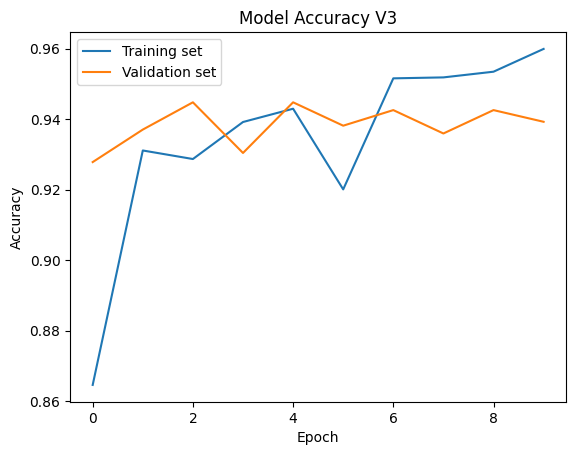

In [71]:

# Accuracy
plt.plot(history_V3.history['accuracy'])
plt.plot(history_V3.history['val_accuracy'])
plt.title('Model Accuracy V3')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training set', 'Validation set'], loc='upper left')
plt.show()


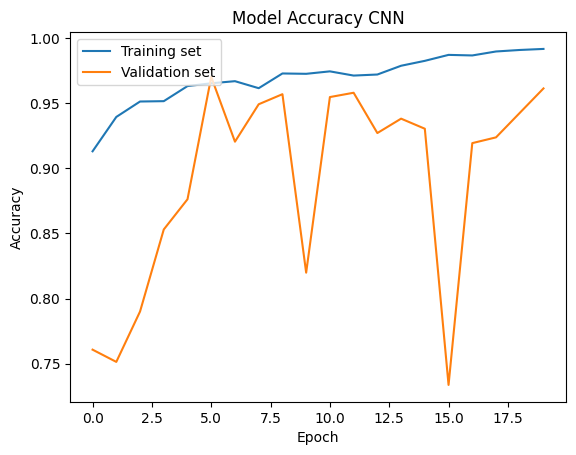

In [72]:
# Accuracy
plt.plot(history_CNN.history['accuracy'])
plt.plot(history_CNN.history['val_accuracy'])
plt.title('Model Accuracy CNN')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training set', 'Validation set'], loc='upper left')
plt.show()


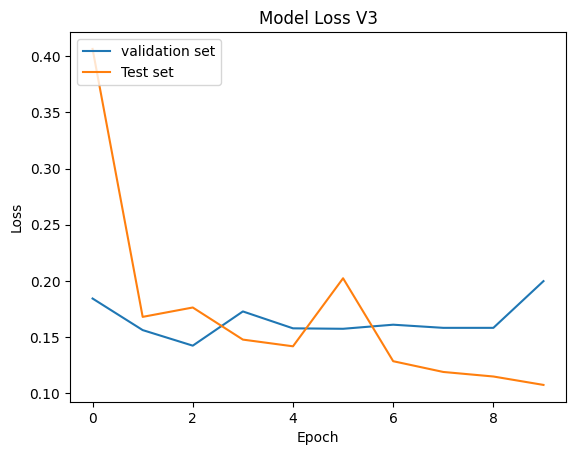

In [73]:
# Loss

plt.plot(history_V3.history['val_loss'])
plt.plot(history_V3.history['loss'])
plt.title('Model Loss V3')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['validation set', 'Test set'], loc='upper left')
plt.show()

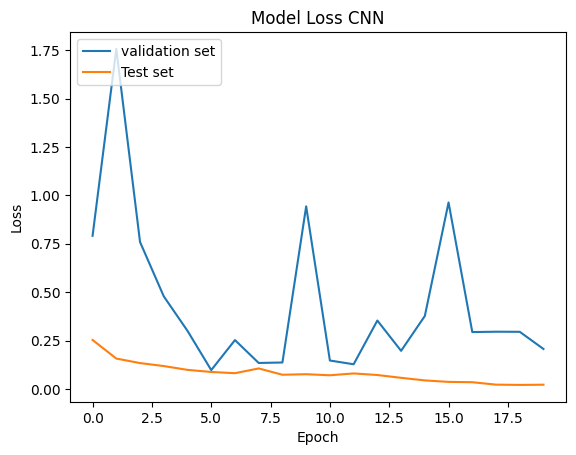

In [74]:
plt.plot(history_CNN.history['val_loss'])
plt.plot(history_CNN.history['loss'])
plt.title('Model Loss CNN')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['validation set', 'Test set'], loc='upper left')
plt.show()

# <font color='purple'> Let's take a look at the Confusion matrix and the F1 score. </font>

In [75]:
from sklearn.metrics import f1_score

# Convert the predicted probabilities to binary class labels
threshold = 0.5
predicted_labels_V3 = (y_pred_V3 >= threshold).astype(int)
predicted_labels_CNN = (y_pred_CNN >= threshold).astype(int)

# Extract true labels from the test_dataset_V3
true_labels_V3 = []
for _, label in test_dataset_V3:  # Iterate through the dataset
    true_labels_V3.extend(label.numpy())  # Convert TensorFlow tensors to NumPy arrays

true_labels_CNN = []
for _, label in test_dataset_CNN:  # Iterate through the dataset
    true_labels_CNN.extend(label.numpy())  # Convert TensorFlow tensors to NumPy arrays

# Convert to a NumPy array for consistency
true_labels_V3 = np.array(true_labels_V3)
true_labels_CNN = np.array(true_labels_CNN)


# Calculate the F1 score
f1_V3 = f1_score(true_labels_V3, predicted_labels_V3)
f1_CNN = f1_score(true_labels_CNN, predicted_labels_CNN)
print(f'F1 score V3: {f1_V3}')
print(f'F1 score CNN: {f1_CNN}')


F1 score V3: 0.7219965177016832
F1 score CNN: 0.7075812274368231


In [76]:
# Compute confusion matrix
cm_V3 = confusion_matrix(true_labels_V3, predicted_labels_V3)
print("Confusion Matrix V3:\n", cm_V3)
print("\n")
cm_CNN = confusion_matrix(true_labels_CNN, predicted_labels_CNN)
print("Confusion Matrix CNN:\n", cm_CNN)

Confusion Matrix V3:
 [[ 71 268]
 [211 622]]


Confusion Matrix CNN:
 [[ 98 241]
 [245 588]]
